# Load packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from numpy import loadtxt
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose, Flatten, Reshape, Add, Concatenate, Dropout
from keras import regularizers
import keras.backend as K

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

import kerastuner as kt
from kerastuner import HyperModel
from kerastuner import Hyperband, RandomSearch

import os
import shutil

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


# Load training data

In [2]:
train_name = 'train6'
size = 4096

train = pd.read_pickle(train_name + '_scaled_indiv.pkl')
freq_train = train.loc[size].drop(['t'], axis = 0)
max_vals_train = train.loc[size+1].drop(['t'], axis = 0)
min_vals_train = train.loc[size+2].drop(['t'], axis = 0)

train = train.drop([size, size+1, size+2], axis = 0)

t = train['t']
X_train = train.T
X_train = X_train.drop(['t'], axis = 0)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
1,1.000000,0.975262,0.940284,0.912588,0.892138,0.876774,0.864920,0.855576,0.848083,0.841972,...,0.357556,0.394147,0.433430,0.474132,0.515596,0.558802,0.609721,0.704737,0.907761,0.964454
5,0.997715,0.997591,0.997225,0.996635,0.995835,0.994842,0.993670,0.992333,0.990842,0.989212,...,0.987167,0.990018,0.992482,0.994567,0.996289,0.997662,0.998702,0.999426,0.999853,0.999999
7,0.999786,0.999573,0.998978,0.998052,0.996837,0.995372,0.993691,0.991825,0.989801,0.987642,...,0.973683,0.979991,0.985272,0.989604,0.993062,0.995728,0.997681,0.998998,0.999748,0.999999
22,0.999656,0.999472,0.998928,0.998066,0.996926,0.995542,0.993945,0.992163,0.990219,0.988136,...,0.976218,0.981863,0.986608,0.990515,0.993649,0.996076,0.997863,0.999073,0.999766,0.999999
23,1.000000,0.978422,0.941563,0.909221,0.883893,0.864296,0.848980,0.836852,0.827121,0.819203,...,0.488635,0.518370,0.547933,0.577663,0.608680,0.643703,0.690858,0.781011,0.902629,0.942365


# Visualize the data

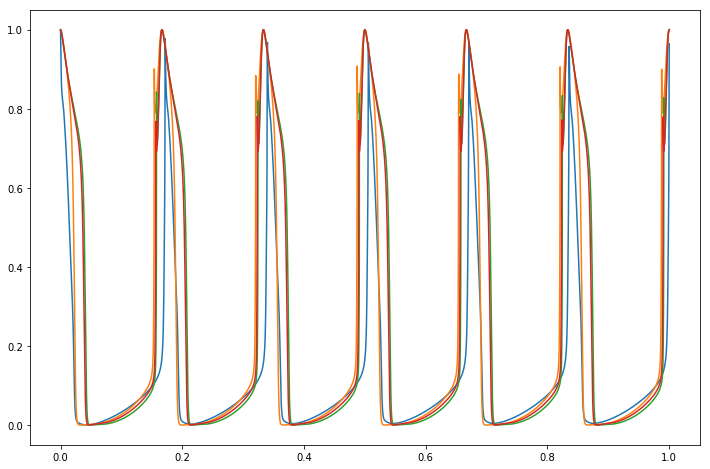

In [3]:
def plot_df(df, n = 4, height = 8, width = 12):
    plt.rcParams['figure.figsize'] = [width, height]
    plt.figure()
    for i in range(n):
        plt.plot(t, df.iloc[i])
        
plot_df(X_train)

# Build the convolutional AE

In [4]:
X_train_array = X_train.values
input_dim, input_size, output_dim = X_train_array.shape[1], X_train_array.shape[0], X_train_array.shape[1]
X_train_AE = X_train_array.reshape(input_size, input_dim, 1)

freq1_train_AE = freq_train.values.reshape(input_size, 1, 1)
freq2_train_AE = max_vals_train.values.reshape(input_size, 1, 1)
freq3_train_AE = min_vals_train.values.reshape(input_size, 1, 1)

freq_train_AE = np.append(freq1_train_AE, np.append(freq2_train_AE, freq3_train_AE, axis = 1), axis = 1)

print(X_train_AE.shape)
print(freq_train_AE.shape)

(494, 4096, 1)
(494, 3, 1)


In [5]:
input_shape1 = (input_dim, 1)
input_layer1 = Input(shape=input_shape1, name="INPUT")
input_shape2 = (3, 1)
input_layer2 = Input(shape=input_shape2, name="INPUT2")

x1 = Conv1D(16, 3, activation='swish', padding='causal')(input_layer1)
x1 = MaxPooling1D(4)(x1)
x1 = Conv1D(8, 3, activation='swish', padding='causal')(x1)
x1 = MaxPooling1D(4)(x1)
x1 = Conv1D(8, 3, activation='swish', padding='causal')(x1)
x1 = MaxPooling1D(2)(x1)
x1 = Flatten()(x1)

x2 = Flatten()(input_layer2)

x = Concatenate(axis = 1)([x1, x2])
x = Dense(128, activation='sigmoid')(x)
feature_layer = Dense(63, activation='sigmoid', name="FEATURES")(x)
x = Dense(1024, activation='swish')(feature_layer)
x = Reshape((128, 8))(x)

x = Conv1DTranspose(8, 3, activation='swish', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1DTranspose(8, 3, activation='swish', padding='same')(x)
x = UpSampling1D(4)(x)
x = Conv1DTranspose(16, 3, activation='swish', padding='same')(x)
x = UpSampling1D(4)(x)

output_layer = Conv1DTranspose(1, 3, activation = 'sigmoid', padding='same', name="OUTPUT")(x)

AE = Model(inputs=[input_layer1, input_layer2], outputs=output_layer)
loss_fn = keras.losses.MeanAbsoluteError()
AE.compile(optimizer='adam', loss=loss_fn)
AE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, 4096, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4096, 16)     64          INPUT[0][0]                      
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1024, 16)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1024, 8)      392         max_pooling1d[0][0]              
______________________________________________________________________________________________

# Train the AE

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
history = AE.fit([X_train_AE, freq_train_AE], X_train_AE, validation_split = 0.2, epochs = 200, callbacks=[early_stopping])

Epoch 1/200
13/13 [==============================] - 17s 169ms/step - loss: 0.4153 - val_loss: 0.3872
Epoch 2/200
13/13 [==============================] - 1s 90ms/step - loss: 0.3642 - val_loss: 0.2694
Epoch 3/200
13/13 [==============================] - 1s 90ms/step - loss: 0.2320 - val_loss: 0.1191
Epoch 4/200
13/13 [==============================] - 1s 88ms/step - loss: 0.1156 - val_loss: 0.1093
Epoch 5/200
13/13 [==============================] - 1s 95ms/step - loss: 0.1092 - val_loss: 0.1035
Epoch 6/200
13/13 [==============================] - 1s 88ms/step - loss: 0.0990 - val_loss: 0.0969
Epoch 7/200
13/13 [==============================] - 1s 88ms/step - loss: 0.0985 - val_loss: 0.0940
Epoch 8/200
13/13 [==============================] - 1s 89ms/step - loss: 0.0960 - val_loss: 0.0929
Epoch 9/200
13/13 [==============================] - 1s 86ms/step - loss: 0.0943 - val_loss: 0.0920
Epoch 10/200
13/13 [==============================] - 1s 83ms/step - loss: 0.0947 - val_loss: 0.09

# Perform hyperparameter optimization

In [ ]:
# input_shape1 = (input_dim, 1)
# input_shape2 = (3, 1)

In [ ]:
# def build_model(hp):
#     my_activation_conv = 'swish' #hp.Choice('activation_conv', values = ['swish', 'relu', 'sigmoid'], default = 'swish')
#     my_activation_dense = 'swish' #hp.Choice('activation_dense', values = ['swish', 'relu', 'sigmoid'], default = 'swish')
#     my_activation_output = 'sigmoid' #hp.Choice('activation_out', values = ['swish', 'relu', 'sigmoid'], default = 'swish')
#     my_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
#     #my_padding_type_conv = hp.Choice('padding_type', ['causal', 'same', 'valid'], default = 'causal')
#     #my_padding_type_deconv = hp.Choice('padding_type', ['same', 'valid'], default = 'same')
#     my_kernel_size_out = hp.Choice('kernel_size_out', values = [2, 3, 4])
    
#     input_layer1 = Input(shape=input_shape1)
#     input_layer2 = Input(shape=input_shape2)
#     x1 = input_layer1

#     my_filters = []
#     my_kernel_size = []
#     my_pool_size = []
#     nr_of_conv_layers = hp.Int('num_layers', 1, 5)
    
#     for i in range(nr_of_conv_layers):
#         my_filters.append(hp.Choice('filters_encoder_' + str(i), values = [2, 4, 16, 32, 64, 128, 256]))
#         my_kernel_size.append(hp.Choice('kernel_size_encoder_' + str(i), values = [2, 3, 4]))
#         my_pool_size.append(hp.Choice('pool_size_encoder_' + str(i), values = [2, 4]))
        
#         x1 = Conv1D(filters=my_filters[i], 
#                     kernel_size=my_kernel_size[i], 
#                     activation=my_activation_conv, 
#                     padding='causal')(x1)
#         x1 = MaxPooling1D(pool_size=my_pool_size[i])(x1)

#     x1 = Flatten()(x1)
#     x2 = Flatten()(input_layer2)
#     x = Concatenate(axis = 1)([x1, x2])
    
#     for i in range(hp.Int('num_layers1', 0, 2)):
#         my_units = hp.Choice('units_dense1_' + str(i), values = [64, 128, 256])
#         x = Dense(units=my_units, activation=my_activation_dense)(x)

#     feature_layer = Dense(63, activation='sigmoid')(x)
#     x = feature_layer
    
#     for i in range(hp.Int('num_layers2', 0, 2)):
#         my_units = hp.Choice('units_dense2_' + str(i), values = [64, 128, 256])
#         x = Dense(units=my_units, activation=my_activation_dense)(x)
        
#     reshape_size = input_dim
#     for i in range(nr_of_conv_layers):
#         reshape_size = reshape_size / my_pool_size[i]
    
#     reshape_size = int(reshape_size)
    
#     x = Dense(reshape_size, activation=my_activation_dense)(x)
#     x = Reshape((reshape_size, 1))(x)

#     for i in range(nr_of_conv_layers):      
#         x = Conv1DTranspose(filters=my_filters[-(i+1)], 
#                             kernel_size=my_kernel_size[-(i+1)], 
#                             activation=my_activation_conv, 
#                             padding='same')(x)
#         x = UpSampling1D(size=my_pool_size[-(i+1)])(x)

#     output_layer = Conv1DTranspose(1, 
#                           kernel_size=my_kernel_size_out, 
#                           activation=my_activation_output, 
#                           padding='same')(x)

#     model = keras.Model([input_layer1, input_layer2], output_layer)

#     model.compile(optimizer=keras.optimizers.Adam(my_learning_rate), 
#               loss=keras.losses.MeanAbsoluteError(), metrics=['accuracy'])

#     return model

In [ ]:
# location = os.getcwd()
# directory = 'hyperband_results_AE'
# path = os.path.join(location, directory)
# try: 
#     shutil.rmtree(path)
# except FileNotFoundError:
#     pass    

# tuner_hp = Hyperband(build_model, 
#                      objective = 'accuracy',
#                      max_epochs = 20,  
#                      factor = 2, 
#                      directory = 'hyperband_results_AE')

# early_stopping = EarlyStopping(monitor='val_loss', patience=15)
# tuner_hp.search([X_train_AE, freq_train_AE], X_train_AE, epochs = 200, validation_split = 0.2, callbacks=[early_stopping])
# best_hypers = tuner_hp.get_best_hyperparameters(num_trials=1)[0]
# AE_temp = tuner_hp.get_best_models(num_models=1)[0]

In [ ]:
# import inspect
# inspect.getmembers(best_hypers)

In [ ]:
# AE_temp.summary()

In [ ]:
# # serialize model to JSON
# model_json = AE_temp.to_json()
# with open("AE_for_Niels.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# #AE_temp.save_weights("model.h5")
# #print("Saved model to disk")

# Determine best number of epochs

In [ ]:
# history_temp = AE_temp.fit([X_train_AE, freq_train_AE], X_train_AE, epochs = 200, validation_split = 0.2, shuffle = True)
# val_acc_per_epoch = history_temp.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' %(best_epoch, ))

In [ ]:
# AE = tuner_hp.hypermodel.build(best_hypers)
# history = AE.fit([X_train_AE, freq_train_AE], X_train_AE, epochs = 200, validation_split = 0.2, callbacks=[early_stopping])

# Train the autoencoder with second loss function

In [12]:
def compute_rms(input_dataseries, output_dataseries):
    rms_dict = {}
    
    nr_of_samples = output_dataseries.shape[0]
    length_of_sample = output_dataseries.shape[1]
            
    for i in range(nr_of_samples):
        rms = 0
        for j in range(length_of_sample):
            rms += (input_dataseries[i][j] - output_dataseries[i][j])**2
        rms_dict[i] = rms / length_of_sample
        
    return rms_dict

decoded_data = AE.predict([X_train_AE, freq_train_AE])
rms_dict = compute_rms(X_train_AE, decoded_data)
rms_df = pd.DataFrame.from_dict(rms_dict)

In [13]:
def calculate_derivative_array(values,dt):
    """
    Calculates the derivative of the value-array array-wise, via finite difference, i.e.
    f' = 1/(2 * dt) * (f[2:-1]-f[0:-3]) \in R^(n-2)
    excluding the first and last elements.
    """
    return 1 / ( 2 * dt ) * (values[:,2:-1,:] - values[:,0:-3,:])

def derivative_loss(dt,avg_rms):
    def loss(y_true,y_pred):
        alpha = 1
        beta = 1/100*avg_rms
        
        mse = K.mean(K.square(y_true - y_pred), axis = 1)
        
        dydx_true = calculate_derivative_array(y_true,dt)
        dydx_pred = calculate_derivative_array(y_pred,dt)
        derivative_loss = K.mean(K.abs(dydx_true-dydx_pred), axis = 1)
        
        return alpha * mse + beta * derivative_loss
    return loss

In [14]:
dt = t[1]-t[0]
average_test_rms = rms_df.mean(axis=1).mean()
loss_fn = derivative_loss(dt, average_test_rms)
AE.compile(optimizer='adam', loss=loss_fn)
history = AE.fit([X_train_AE, freq_train_AE], X_train_AE, epochs = 200, validation_split = 0.2, callbacks=[early_stopping])

Epoch 1/200
13/13 [==============================] - 17s 147ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 2/200
13/13 [==============================] - 1s 94ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 3/200
13/13 [==============================] - 1s 95ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/200
13/13 [==============================] - 1s 92ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 5/200
13/13 [==============================] - 1s 96ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 6/200
13/13 [==============================] - 1s 91ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/200
13/13 [==============================] - 1s 100ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/200
13/13 [==============================] - 1s 96ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/200
13/13 [==============================] - 1s 90ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 10/200
13/13 [==============================] - 1s 86ms/step - loss: 0.0016 - val_loss: 0.0

# Extract features training set

In [15]:
intermediate_layer_model = Model(inputs=[input_layer1, input_layer2], outputs=feature_layer)
intermediate_output = intermediate_layer_model([X_train_AE, freq_train_AE])

In [16]:
features_df = pd.DataFrame(intermediate_output.numpy())
features_df.to_pickle(train_name + '_AE_latentSpace.pkl')
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.649757,0.374820,0.283404,0.152555,0.576685,0.606270,0.316407,0.560236,0.466318,0.505264,...,0.476854,0.627443,0.031229,0.926032,0.132722,0.902248,0.417471,0.255176,0.521572,0.115609
1,0.391751,0.713018,0.628274,0.193654,0.792829,0.715885,0.901111,0.508334,0.300739,0.650186,...,0.960667,0.647063,0.070370,0.361068,0.788259,0.903882,0.922073,0.205578,0.473465,0.283946
2,0.980075,0.385989,0.243884,0.065160,0.503596,0.710616,0.441175,0.258572,0.299632,0.169158,...,0.934851,0.248272,0.039902,0.249979,0.769427,0.929762,0.957868,0.148317,0.850222,0.738870
3,0.977422,0.385056,0.294540,0.077070,0.596516,0.623169,0.595097,0.355316,0.260078,0.166465,...,0.915897,0.267951,0.045003,0.308649,0.794091,0.926385,0.949324,0.123994,0.856282,0.746269
4,0.316669,0.439399,0.236718,0.261827,0.766231,0.658649,0.436950,0.506148,0.562814,0.669915,...,0.566869,0.716030,0.084216,0.860418,0.158786,0.865565,0.377686,0.353630,0.326606,0.066105


# Store decoder

In [17]:
layer_names = [layer.name for layer in AE.layers]
feature_layer_idx = layer_names.index('FEATURES')

In [18]:
decoder_input_shape = AE.layers[feature_layer_idx+1].get_input_shape_at(0)
decoder_input = Input(shape = decoder_input_shape[1])
x = decoder_input
for layer in AE.layers[feature_layer_idx+1:]:
    x = layer(x)
    
decoder = Model(inputs=decoder_input, outputs=x)

#decoder_input = AE.get_layer('FEATURES').input
#decoder_output = AE.get_layer('OUTPUT').output
#decoder = Model(inputs=decoder_input, outputs=decoder_output)
# serialize model to JSON
model_json = decoder.to_json()
with open(train_name + "_decoder.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
decoder.save_weights(train_name + "_decoder.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              65536     
_________________________________________________________________
reshape (Reshape)            (None, 128, 8)            0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            200       
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 256, 8)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 256, 8)            200       
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 1024, 8)           0   

## Load test data

In [7]:
test_name = 'test3'

test = pd.read_pickle(test_name + '_scaled_indiv.pkl')
freq_test = test.loc[size].drop(['t'], axis = 0)
max_vals_test = test.loc[size+1].drop(['t'], axis = 0)
min_vals_test = test.loc[size+2].drop(['t'], axis = 0)

test = test.drop([size, size+1, size+2], axis = 0)

t = test['t']
X_test = test.T
X_test = X_test.drop(['t'], axis = 0)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
1,0.999618,0.999523,0.999254,0.998824,0.998248,0.997538,0.996706,0.995763,0.994720,0.993586,...,0.989991,0.992289,0.994244,0.995877,0.997207,0.998255,0.999039,0.999579,0.999894,0.999999
4,1.000000,0.973158,0.932608,0.900502,0.877260,0.860314,0.847719,0.838246,0.831089,0.825690,...,0.356770,0.390182,0.425577,0.462184,0.499661,0.538888,0.584242,0.661657,0.896799,0.978369
6,0.999591,0.999545,0.999411,0.999196,0.998904,0.998539,0.998105,0.997608,0.997050,0.996435,...,0.995565,0.996553,0.997403,0.998123,0.998716,0.999190,0.999549,0.999801,0.999949,1.000000
11,0.922937,0.922908,0.922819,0.922667,0.922452,0.922172,0.921824,0.921406,0.920916,0.920353,...,0.997462,0.997863,0.998219,0.998530,0.998794,0.999011,0.999182,0.999306,0.999382,0.999411
17,1.000000,0.941217,0.885515,0.852904,0.832396,0.818466,0.808687,0.801751,0.796803,0.793226,...,0.263755,0.289382,0.320502,0.357009,0.397947,0.442015,0.489030,0.545097,0.744385,0.980373


In [8]:
X_test_array = X_test.values
input_dim, input_size, output_dim = X_test_array.shape[1], X_test_array.shape[0], X_test_array.shape[1]
X_test_AE = X_test_array.reshape(input_size, input_dim, 1)

freq1_test_AE = freq_test.values.reshape(input_size, 1, 1)
freq2_test_AE = max_vals_test.values.reshape(input_size, 1, 1)
freq3_test_AE = min_vals_test.values.reshape(input_size, 1, 1)

freq_test_AE = np.append(freq1_test_AE, np.append(freq2_test_AE, freq3_test_AE, axis = 1), axis = 1)

print(X_test_AE.shape)
print(freq_test_AE.shape)

(118, 4096, 1)
(118, 3, 1)


# Extract features test set

In [20]:
intermediate_layer_model = Model(inputs=[input_layer1, input_layer2], outputs=feature_layer)
intermediate_output = intermediate_layer_model([X_test_AE, freq_test_AE])

In [21]:
features_df = pd.DataFrame(intermediate_output.numpy())
features_df.to_pickle(test_name + '_AE_latentSpace.pkl')
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.986513,0.327854,0.548082,0.233430,0.392345,0.663867,0.547375,0.366008,0.201439,0.085911,...,0.920159,0.157968,0.059014,0.127716,0.756851,0.858616,0.967945,0.168207,0.863735,0.906884
1,0.980727,0.449864,0.129875,0.031818,0.202286,0.588246,0.057414,0.449695,0.514973,0.208891,...,0.255274,0.305680,0.015774,0.864795,0.142235,0.969834,0.432788,0.189146,0.897666,0.494028
2,0.988056,0.244488,0.929495,0.613297,0.658902,0.370315,0.702969,0.653324,0.134248,0.284536,...,0.806821,0.121851,0.340487,0.267378,0.804897,0.945077,0.949076,0.236713,0.890496,0.820305
3,0.477629,0.174141,0.932012,0.975277,0.849134,0.248344,0.952661,0.558940,0.653248,0.861135,...,0.870416,0.616021,0.959445,0.134733,0.788255,0.649125,0.819570,0.782838,0.420537,0.320148
4,0.644977,0.457609,0.307556,0.115220,0.624587,0.678397,0.239526,0.606810,0.522074,0.486206,...,0.592711,0.667144,0.022098,0.941216,0.107341,0.919095,0.489923,0.242590,0.548250,0.122974


## Compare input and decoded data

In [22]:
train_error = AE.evaluate([X_train_AE, freq_train_AE], X_train_AE)
test_error = AE.evaluate([X_test_AE, freq_test_AE], X_test_AE)

print('Train loss: %f' %train_error)
print('Test loss: %f' %test_error)

4/4 [==============================] - 0s 24ms/step - loss: 0.0017
Train loss: 0.001613
Test loss: 0.001725


In [23]:
#decoded_data = AE.predict(X_train_AE)
decoded_data = AE.predict([X_test_AE, freq_test_AE])
#decoded_data = AE.predict([X_train_AE, freq_train_AE])

3


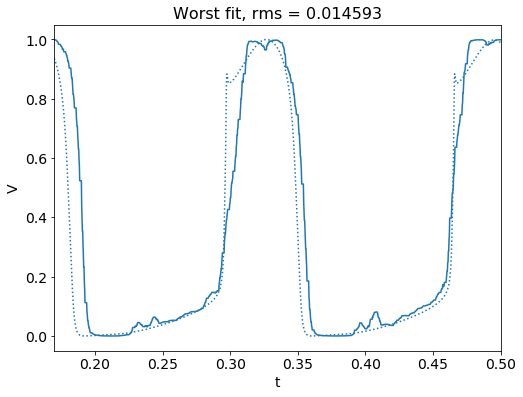

66


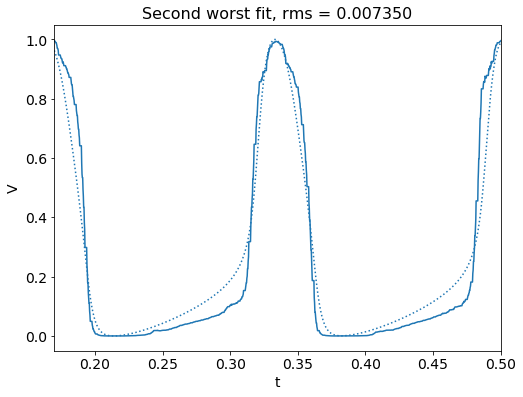

59


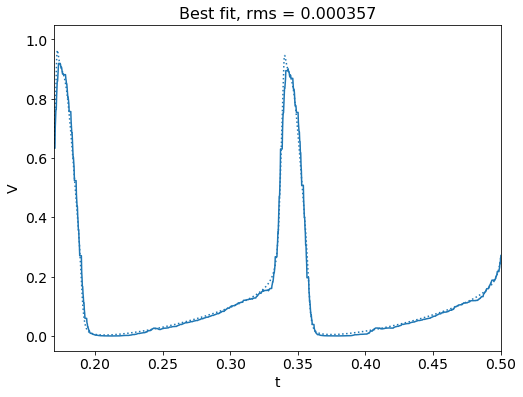

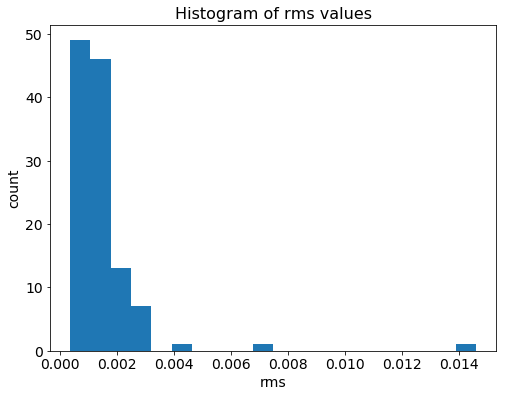

Average rms = 0.001506


In [24]:
def plot_best_and_worst_fit(input_dataseries, output_dataseries, height = 6, width = 8):
    plt.rcParams['figure.figsize'] = [width, height]
    rms_dict = {}
    
    nr_of_samples = output_dataseries.shape[0]
    length_of_sample = output_dataseries.shape[1]
            
    for i in range(nr_of_samples):
        rms = 0
        for j in range(length_of_sample):
            rms += (input_dataseries[i][j] - output_dataseries[i][j])**2
        rms_dict[i] = rms / length_of_sample
        
    max_key = 3 #max(rms_dict.items(), key=operator.itemgetter(1))[0]  
    rms_dict2 = rms_dict.copy()
    rms_dict2.pop(max_key)
    max2_key = max(rms_dict2.items(), key=operator.itemgetter(1))[0]   
    min_key = 59 #min(rms_dict.items(), key=operator.itemgetter(1))[0]
    
    print(max_key)
    plt.figure()
    line, = plt.plot(t, input_dataseries[max_key], ':')
    plt.plot(t, output_dataseries[max_key], color = line.get_color())
    plt.title('Worst fit, rms = %f' %rms_dict[max_key], fontsize = 16)
    plt.xlim([0.17, 0.5])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('t', fontsize = 14)
    plt.ylabel('V', fontsize = 14)
    plt.show()
    
    print(max2_key)
    plt.figure()
    line, = plt.plot(t, input_dataseries[max2_key], ':')
    plt.plot(t, output_dataseries[max2_key], color = line.get_color())
    plt.title('Second worst fit, rms = %f' %rms_dict[max2_key], fontsize = 16)
    plt.xlim([0.17, 0.5])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('t', fontsize = 14)
    plt.ylabel('V', fontsize = 14)
    plt.show()
    
    print(min_key)
    plt.figure()
    line, = plt.plot(t, input_dataseries[min_key], ':')
    plt.plot(t, output_dataseries[min_key], color = line.get_color())
    plt.title('Best fit, rms = %f' %rms_dict[min_key], fontsize = 16)
    plt.xlim([0.17, 0.5])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('t', fontsize = 14)
    plt.ylabel('V', fontsize = 14)
    plt.show()
    
    return rms_dict
        
rms_dict = plot_best_and_worst_fit(X_test_AE, decoded_data)
#rms_dict = plot_best_and_worst_fit(X_train_AE, decoded_data)
rms_df = pd.DataFrame.from_dict(rms_dict)

plt.figure()
plt.hist(rms_df, bins = 20)
#plt.plot([rms_df.mean(axis=1), rms_df.mean(axis=1)], [0, 50], 'r:', linewidth=2)
plt.title('Histogram of rms values', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('rms', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.show()

print('Average rms = %f' %rms_df.mean(axis=1))